# Zero-shot similarity search

In this notebook, we will use the the generated embeddings to search for similar galaxies.

In [2]:
from astroclip.utils import load_config, format_axes, create_dir_if_required
from astroclip.training_utils import create_dataloaders, get_cross_modal_transforms
import matplotlib.pyplot as plt
from utils import ToRGB
from torchvision.transforms import CenterCrop

import torch
import numpy as np

In [181]:
!mkdir out

mkdir: out: File exists


## Load the data, and generated embeddings

In [3]:
config, hparams = load_config('local', 'generate_embeddings')

cache_dir = config['cache_dir']
output_dir = config['output_dir']

batch_size = hparams['batch_size']
num_workers = config['num_workers']

dataset, train_loader, val_loader = create_dataloaders(cache_dir, batch_size, num_workers, val_drop_last=False)
val_dataset = dataset['test']

# load all of the embedded spectra and images, as well as the corresponding redshifts
all_spectrum_embeddings = torch.load(f'out/spectrum_embeddings.pt').numpy()
all_image_embeddings = torch.load(f'out/image_embeddings.pt').numpy()
all_redshifts = dataset['test']['redshift'].numpy()

# load the valid indices, see downstream_tasks/README.md for more information on exactly what this is
valid_indices = torch.load(f'out/valid_indices.pt').numpy()

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

## Compute the cosine similarity between all of the embeddings

In [4]:
# idx_query = [] + list(np.random.randint(0, len(val_dataset), 4))
idx_query = [300, 2650, 4253, 35171, 37886]

# double check that all of the above indices are valid
for idx in idx_query:
    assert idx in valid_indices

# extract the query image-spectra pairs from the dataset    
query = val_dataset.select(idx_query)
    
# these arrays will store the most similar galaxies for each query
idx_sp_sp = []
idx_im_im = []
idx_sp_im = []
idx_im_sp = []

# for each query galaxy, find the most similar galaxies (in-modal and cross-modal)
for idx in idx_query:
    sp_sp_sim = all_spectrum_embeddings[idx] @ all_spectrum_embeddings.T 
    im_im_sim = all_image_embeddings[idx] @ all_image_embeddings.T
    sp_im_sim = all_spectrum_embeddings[idx] @ all_image_embeddings.T
    im_sp_sim = all_image_embeddings[idx] @ all_spectrum_embeddings.T
    
    # for the given query galaxy, save the index for the 3 most similar galaxies down
    idx_sp_sp.append(np.argsort(sp_sp_sim)[::-1][:3])
    idx_im_im.append(np.argsort(im_im_sim)[::-1][:3])
    idx_sp_im.append(np.argsort(sp_im_sim)[::-1][:3])
    idx_im_sp.append(np.argsort(im_sp_sim)[::-1][:3])
    
# Now we extract the 3 most similar galaxies from the val_dataset for each query galaxy
sp_sp = [val_dataset.select(idx) for idx in idx_sp_sp]
im_im = [val_dataset.select(idx) for idx in idx_im_im]
sp_im = [val_dataset.select(idx) for idx in idx_sp_im]
im_sp = [val_dataset.select(idx) for idx in idx_im_sp]

# E.g., sp_sp are the most similar galaxies based on spectrum to spectrum embedding cosine similarity
# It has a length of 3, where sp_sp[0]['spectrum'] are the 3 most similar spectra to query['spectrum'][0]
sp_sp

[Dataset({
     features: ['image', 'spectrum', 'redshift', 'targetid'],
     num_rows: 3
 }),
 Dataset({
     features: ['image', 'spectrum', 'redshift', 'targetid'],
     num_rows: 3
 }),
 Dataset({
     features: ['image', 'spectrum', 'redshift', 'targetid'],
     num_rows: 3
 }),
 Dataset({
     features: ['image', 'spectrum', 'redshift', 'targetid'],
     num_rows: 3
 }),
 Dataset({
     features: ['image', 'spectrum', 'redshift', 'targetid'],
     num_rows: 3
 })]

## Plotting the similar galaxies, by image

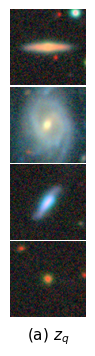

In [5]:
# First we plot the images of the query galaxies
def plot_query_galaxy_images(query_images):
    query_images = CenterCrop(96)(query_images.permute(0, 3, 1, 2))
    query_images = ToRGB()(query_images)
    
    n_rows = 4
    fig, ax = plt.subplots(figsize=(1, n_rows), nrows=n_rows, ncols=1)
    
    [ax[i].imshow(query_images[i]) for i in range(n_rows)]
    [ax[i].axis('off') for i in range(n_rows)]
    plt.subplots_adjust(hspace=0.02, wspace=0)
    ax[n_rows-1].set_title(r'(a) $z_{q}$', fontsize=11, y=-0.4)
    
    return fig, ax

fig, ax = plot_query_galaxy_images(query['image'])
plt.savefig('out/sim_search_query_images.png', bbox_inches='tight')

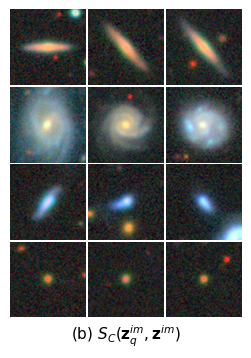

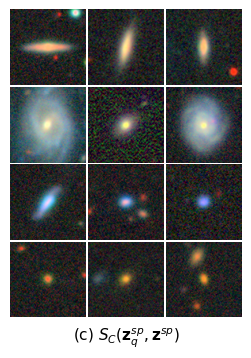

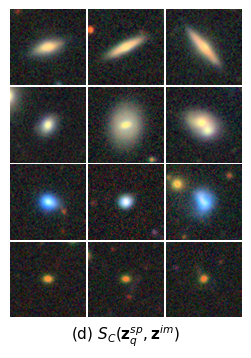

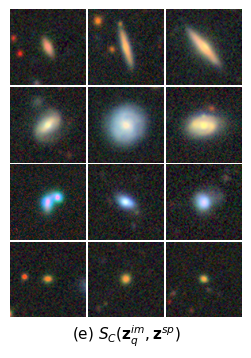

In [6]:
def plot_image(images, title):
    nrows, ncols = 4, 3
    fig, ax = plt.subplots(figsize=(ncols, nrows), nrows=nrows, ncols=ncols)
    
    for row in range(nrows):
        for col in range(ncols):
            similar_image = images[row]['image'][col]
            similar_image = CenterCrop(96)(similar_image.permute(2, 0, 1))
            similar_image = ToRGB()(similar_image)
            
            ax[row, col].imshow(similar_image)
            
    [ax[row, col].axis('off') for row in range(nrows) for col in range(ncols)]
    plt.subplots_adjust(hspace=0.02, wspace=0.02)
    
    ax[3, 1].set_title(title, fontsize=11, y=-0.4)
            
    return fig, ax

latex_im_im = r'$S_{C}(\mathbf{z}_{q}^{im}, \mathbf{z}^{im})$'
latex_sp_sp = r'$S_{C}(\mathbf{z}_{q}^{sp}, \mathbf{z}^{sp})$'
latex_sp_im = r'$S_{C}(\mathbf{z}_{q}^{sp}, \mathbf{z}^{im})$'
latex_im_sp = r'$S_{C}(\mathbf{z}_{q}^{im}, \mathbf{z}^{sp})$'

plot_image(im_im, title=r'(b) ' + latex_im_im)
plt.savefig('out/sim_search_img_img.png', bbox_inches='tight')

plot_image(sp_sp, title=r'(c) ' + latex_sp_sp)
plt.savefig('out/sim_search_sp_sp.png', bbox_inches='tight')

plot_image(sp_im, title=r'(d) ' + latex_sp_im)
plt.savefig('out/sim_search_sp_im.png', bbox_inches='tight')

plot_image(im_sp, title=r'(e) ' + latex_im_sp)
plt.savefig('out/sim_search_im_sp.png', bbox_inches='tight')

## Plotting the similar galaxies, by spectra

In [7]:
def plot_spectrum(
        query_spectrum, 
        query_image, 
        retrieved_spectra_im_im, 
        retrieved_spectra_sp_sp, 
        retrieved_spectra_im_sp, 
        retrieved_spectra_sp_im,  
        inset_ax_pos,
        titles = None,
        xlim = None,
        query_spec_color='darkred'
):
    fig, ax = plt.subplots(figsize=(16, 3), nrows=1, ncols=4)
    
    subset = np.arange(0, 7781, 10)
    wavelengths = np.linspace(3600.0, 9824.0, 7781)
    n_spectrum = 3

    for idx, retrieved_spectra in enumerate([retrieved_spectra_im_im, retrieved_spectra_sp_sp, retrieved_spectra_im_sp, retrieved_spectra_sp_im]):
        for i in range(n_spectrum):
            if i != n_spectrum - 1:
                ax[idx].plot(
                    wavelengths[subset], 
                    retrieved_spectra[i].flatten()[subset], alpha=0.5, lw=0.7, color='grey'
                )
            else: 
                ax[idx].plot(
                    wavelengths[subset], 
                    retrieved_spectra[i].flatten()[subset], alpha=0.5, lw=0.7, label='Retrieved Spectra', color='grey'
                )
        
        if titles is not None:
            ax[idx].set_title(titles[idx], fontsize=11, y=-0.37)
            
        ax[idx].plot(wavelengths[subset], query_spectrum[subset], label='Query spectrum', lw=0.7, color=query_spec_color)
        
        if xlim is not None:
            ax[idx].set_ylim(*xlim)

        
        ax[idx].set_xlabel(r'$\lambda$')

        inset_ax = fig.add_axes(inset_ax_pos)
        image = ToRGB()(query_image)
        inset_ax.imshow(image)
        inset_ax.axis('off')
    
    ax[0].set_ylabel('Flux')
    ax[0].legend()

    return fig, ax

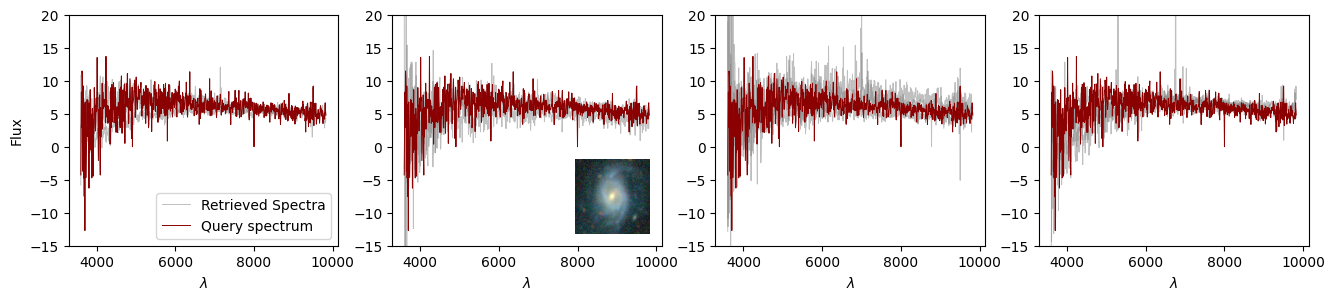

In [8]:
idx = 1

fig, ax = plot_spectrum(
    query['spectrum'][idx].flatten(), 
    query['image'][idx],  
    im_im[idx]['spectrum'],
    sp_sp[idx]['spectrum'],
    im_sp[idx]['spectrum'], 
    sp_im[idx]['spectrum'],
    [0.405, 0.15, 0.12, 0.25],
    # [
    #     '(a) ' + latex_im_im, '(b) ' + latex_sp_sp, '(c) ' + latex_im_sp, '(d) ' + latex_sp_im
    # ],
    xlim=(-15, 20)
)

plt.savefig('out/sim_search_spec_1', bbox_inches='tight')

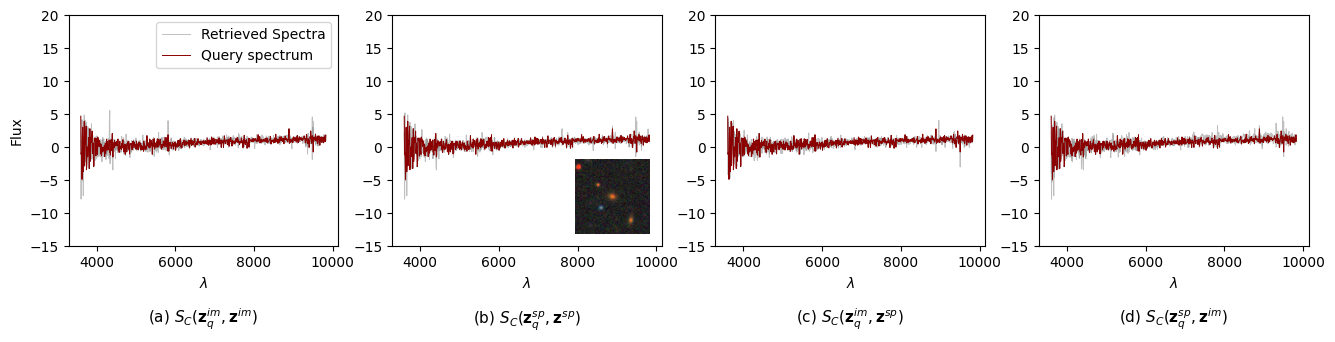

In [9]:
idx = 4

fig, ax = plot_spectrum(
    query['spectrum'][idx].flatten(), 
    query['image'][idx],  
    im_im[idx]['spectrum'],
    sp_sp[idx]['spectrum'],
    im_sp[idx]['spectrum'], 
    sp_im[idx]['spectrum'],
    [0.405, 0.15, 0.12, 0.25],
    [
        '(a) ' + latex_im_im, '(b) ' + latex_sp_sp, '(c) ' + latex_im_sp, '(d) ' + latex_sp_im
    ],
    xlim=(-15, 20)
)

plt.savefig('out/sim_search_spec_2', bbox_inches='tight')